In [1]:
import skeliner as sk
import trimesh
from pathlib import Path

import matplotlib.pyplot as plt


In [2]:
MESH_PATH = Path("../data/720575940545220339.obj")
mesh = trimesh.load(MESH_PATH, process=False)

In [ ]:
skel = sk.skeletonize(mesh, 
    soma_probe_radius_mult=10.0,
    soma_density_threshold=0.30,
    soma_dilation_steps=1,
    collapse_soma=True, # default
    bridge_components=True, # default
    prune_tiny_neurites=True, # default
)

SyntaxError: positional argument follows keyword argument (3163799171.py, line 6)

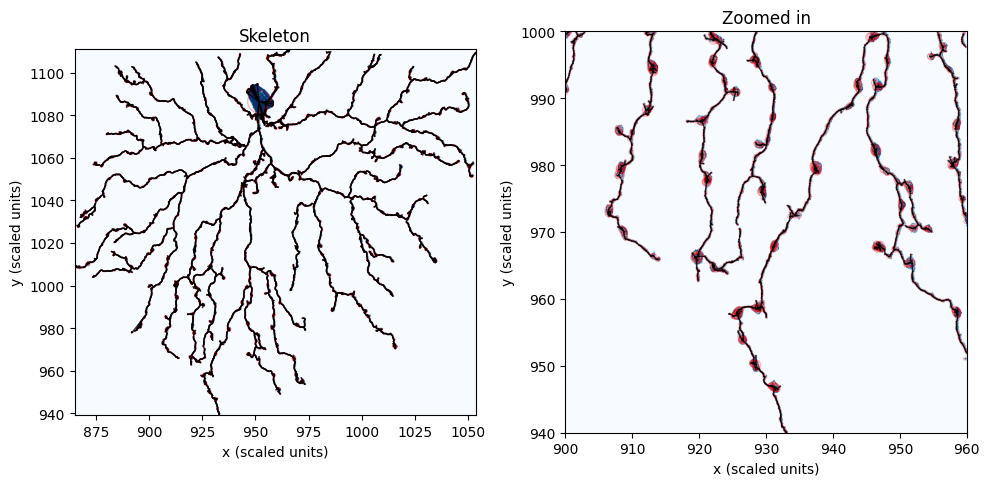

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
sk.plot2d(
    skel, mesh,
    plane="xy",
    scale=1e-3, # nm → µm 
    draw_edges=True,
    ax=ax[0]
)
sk.plot2d(
    skel, mesh,
    plane="xy",
    scale=1e-3,  
    xlim=(900, 960),
    ylim=(940, 1000),
    draw_edges=True,
    ax=ax[1]
)
ax[0].set_title("Skeleton")
ax[1].set_title("Zoomed in")

fig.tight_layout()

In [5]:
%load_ext watermark
%watermark --time --date --timezone --updated --python --iversions --watermark

Last updated: 2025-05-17 01:14:40CEST

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 9.2.0

matplotlib: 3.10.3
skeliner  : 0.1.0
trimesh   : 4.6.9

Watermark: 2.5.0

